# Adi-GAN-s

In [7]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchmetrics
import torchvision
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.callbacks import ModelCheckpoint
import os
import cv2

In [9]:
# constants and configurations
TRAIN_DIR = '/kaggle/input/edges2shoes-dataset/train'
VAL_DIR = '/kaggle/input/edges2shoes-dataset/val'
LR = 2e-4
BATCH_SIZE = 4
IMG_SIZE = 256
CHANNELS_IMG = 3
EPOCHS = 15
BETA1 = 0.5
BETA2 = 0.999
L1_LAMBDA = 100

both_transform = A.Compose(
    [A.HorizontalFlip(p=0.5),
     A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value = 255.0),
     ToTensorV2()
    ],
    additional_targets={'sketch': 'image'}
)

## Getting and Exploring the data

In [10]:
# Number of training and testing examples
len(os.listdir(TRAIN_DIR)), len(os.listdir(VAL_DIR))

(49825, 200)

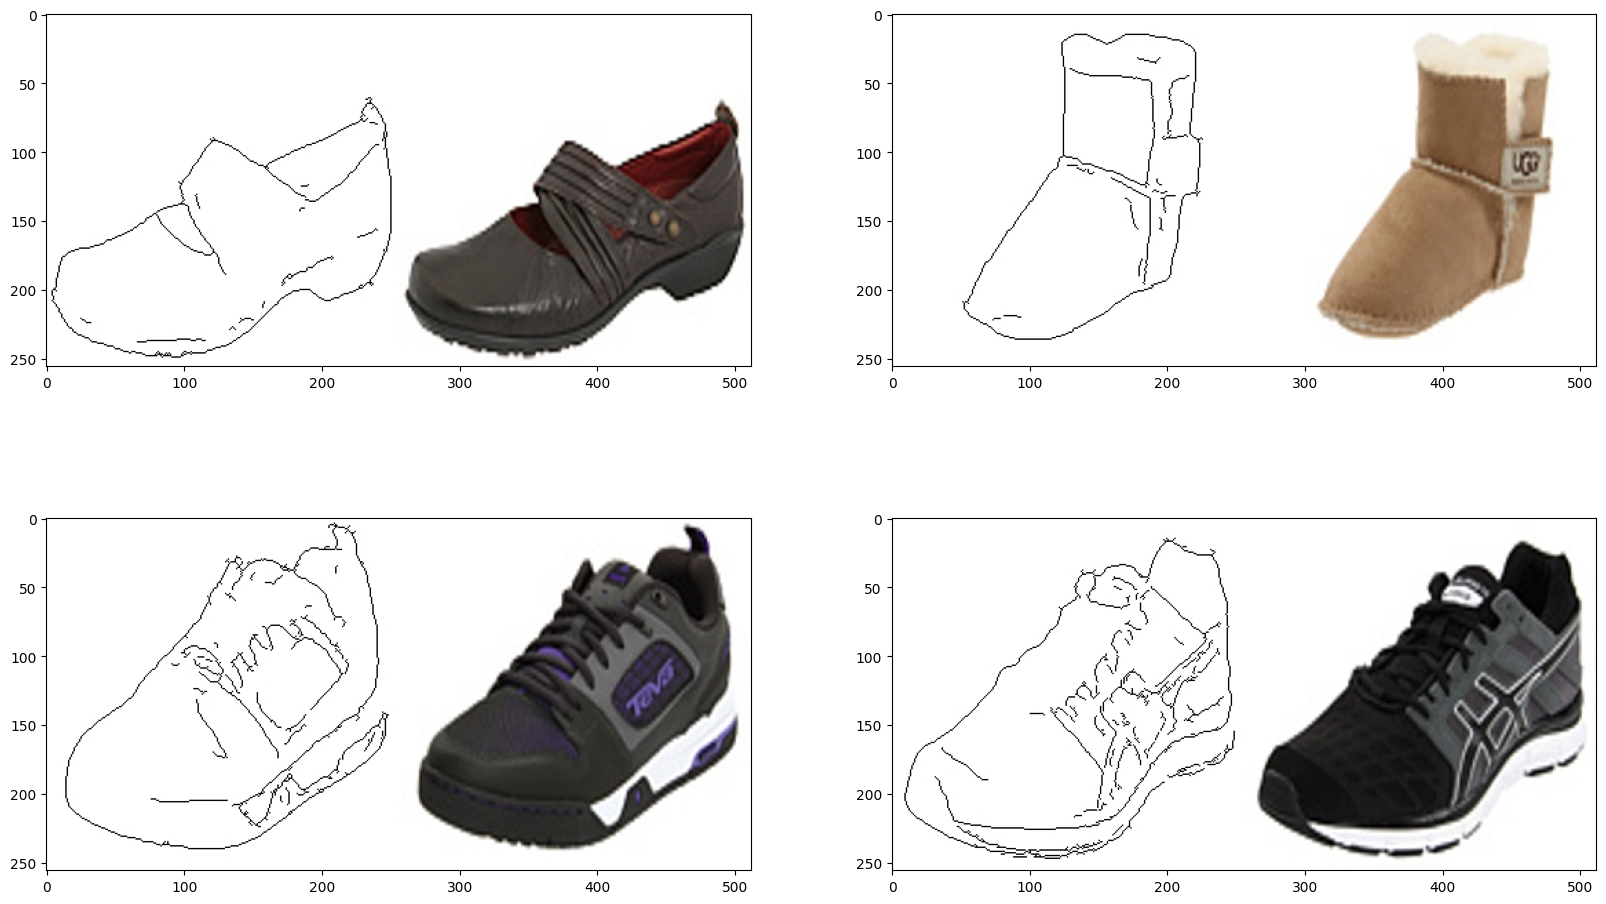

(256, 512, 3)

In [11]:
# Leading an image and visualize it
def get_image(path: str):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

train_path = os.listdir(TRAIN_DIR)
fig, ax = plt.subplots(2, 2, figsize= (20, 12))

x, y = 0, 0
for i in range(4):
    n = np.random.randint(0, len(train_path))
    path = os.path.join(TRAIN_DIR, train_path[n])
    img = get_image(path)
    ax[x][y].imshow(img)
    y += 1
    if y == 2:
        y = 0
        x = 1
plt.show()
img.shape

So the sketch is beside the real image in the same picture

In [12]:
# divide sketch and image
def divide_sketch_image(img):
    sketch = img[:, :len(img), :]
    image = img[:, len(img):, :]
    return sketch, image

sketch, image = divide_sketch_image(get_image(path))
sketch.shape, image.shape, sketch.max(), image.max(), sketch.min(), image.min()

((256, 256, 3), (256, 256, 3), 255, 255, 0, 0)

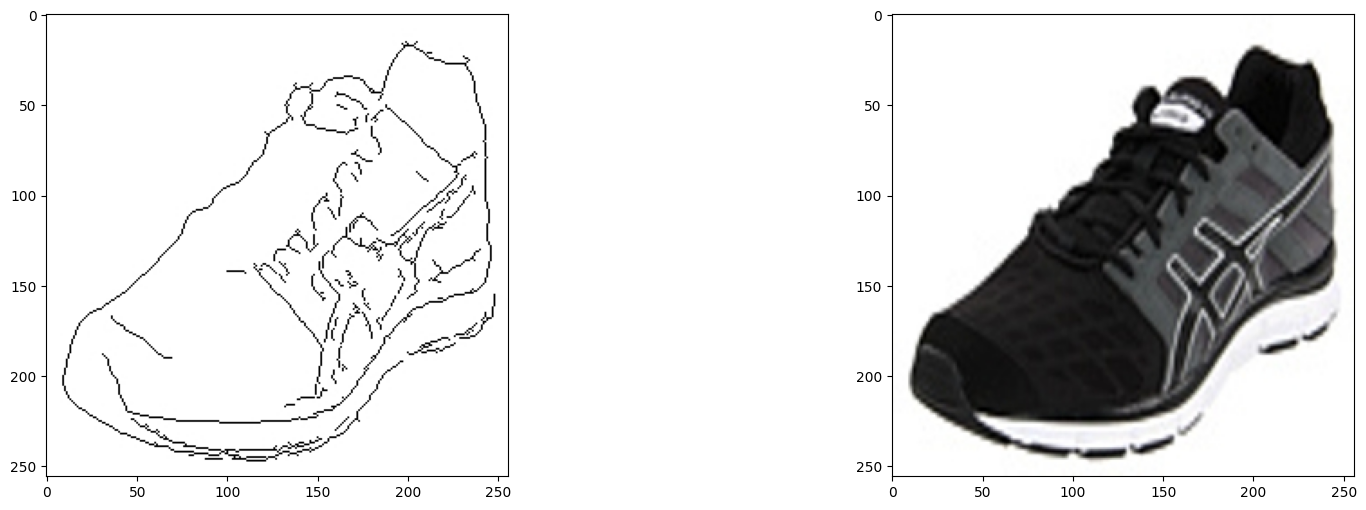

In [13]:
# View the sketch and image after the split
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].imshow(sketch)
ax[1].imshow(image);

## Creating our data module and data set

In [14]:
# Dataset class
class CustomDataset(Dataset):
    def __init__(self, sketches, images):
        self.sketches = torch.tensor(sketches).float()
        self.images = torch.tensor(images).float()
        
    def __len__(self):
        return len(self.sketches)

    def __getitem__(self, idx):
        sketch = self.sketches[idx]
        image = self.images[idx]
        return {
            'sketch': sketch,
            'image': image
        }
        

In [15]:
# Testing our custom dataset
sk = []
imgs = []
for p in train_path[:10]:
    path = os.path.join(TRAIN_DIR, p)
    img = get_image(path)
    sketch, image = divide_sketch_image(img)
    sk.append(sketch)
    imgs.append(image)

sk = np.array(sk)
imgs = np.array(imgs)

dataset = CustomDataset(sk, imgs)
dataset

In [16]:
# Viewing our dataset content
item = dataset[0]
item['sketch'].shape, item['image'].shape, dataset.images.shape, dataset.sketches.shape

(torch.Size([256, 256, 3]),
 torch.Size([256, 256, 3]),
 torch.Size([10, 256, 256, 3]),
 torch.Size([10, 256, 256, 3]))

So our shape is (10, 256, 256, 3) --> (batch, height, width, channel). we need to change it as pytorch uses images of shape (batch, channel, height, width), also as we have ~50000 images so it is better to load when needed

In [17]:
class AdiGansDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.data_paths = os.listdir(self.data_dir)
        
    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        p = self.data_paths[idx]
        path = os.path.join(self.data_dir, p)
        img = self.get_image(path)
        sketch, image = self.divide_sketch_image(img)
        
        augmentations = both_transform(image=image, sketch=sketch)
        sketch, image = augmentations['sketch'], augmentations['image']
        return {
            'sketch': sketch,
            'image': image
        }
    
    def divide_sketch_image(self, img):
        sketch = img[:, :len(img), :]
        image = img[:, len(img):, :]
        return sketch, image
    
    def get_image(self, path: str):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

In [18]:
# Testing our custom dataset
dataset = AdiGansDataset(TRAIN_DIR)

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


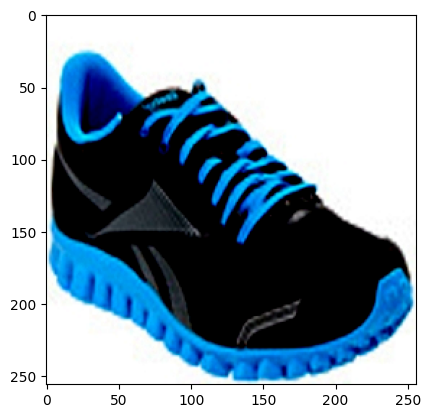

In [19]:
# Viewing our dataset content
item = dataset[243]
print(item['sketch'].shape, item['image'].shape)
plt.imshow(item['image'].numpy().transpose((1, 2, 0)));

In [20]:
# Creating our lighting data module
class AdiGansDataModule(pl.LightningDataModule):
    def __init__(self, train_dir, val_dir, batch_size=BATCH_SIZE):
        super().__init__()
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.batch_size = batch_size
    
    def prepare_data(self):
        pass 
    
    def setup(self, stage=None):
        self.train_dataset = AdiGansDataset(self.train_dir)
        self.val_dataset = AdiGansDataset(self.val_dir)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=3)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=3)
        

In [21]:
dm = AdiGansDataModule(TRAIN_DIR, VAL_DIR)
dm.setup()

In [22]:
next(iter(dm.val_dataloader()))['sketch'].shape

torch.Size([4, 3, 256, 256])

In [23]:
len(dm.val_dataloader()), len(dm.train_dataloader())

(50, 12457)

## Creating our Discriminator and Generator Model

In [24]:
# Discriminator
class DiscCNNBlock(nn.Module):
    '''
    The CNN block for the discriminator model
    '''
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        # initial layer
        self.initial = nn.Sequential(
          nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),  #
          nn.LeakyReLU(0.2)  
        )
        # making the rest layers except the final
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            stride = 1 if feature==features[-1] else 2
            layers.append(DiscCNNBlock(in_channels, feature, stride=stride))
            in_channels = feature
        # final layer
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'))

        self.model = nn.Sequential(*layers)


    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

def test():
    print("Testing Discriminator")
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator()
    preds = model(x, y)
    print(preds.shape)

test()

Testing Discriminator
torch.Size([1, 1, 26, 26])


In [25]:
# Generator
class GenCNNBlock(nn.Module):
    '''
    The CNN block for the generator model
    '''
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        # Getting conv2d or conv2dtranspose
        cnn = nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect") if down else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        # Getting relu or leakyrelu
        act = nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2)
        # Layers
        self.conv = nn.Sequential(
            cnn,
            nn.BatchNorm2d(out_channels),
            act
        ) # Ck: Added batchnorm layer
        # Adding dropout
        if use_dropout:
            self.conv.add_module("dropout", nn.Dropout(0.5)) # CDk: Added dropout layer


    def forward(self, x):
        return self.conv(x)
    
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()

        self.initial = nn.Sequential(
          nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
          nn.LeakyReLU(0.2, inplace=True)
        )

        self.down1 = GenCNNBlock(features, features*2, down=True, act="LeakyReLU", use_dropout=False)
        self.down2 = GenCNNBlock(features*2, features*4, down=True, act="LeakyReLU", use_dropout=False)
        self.down3 = GenCNNBlock(features*4, features*8, down=True, act="LeakyReLU", use_dropout=False)
        self.down4 = GenCNNBlock(features*8, features*8, down=True, act="LeakyReLU", use_dropout=False)
        self.down5 = GenCNNBlock(features*8, features*8, down=True, act="LeakyReLU", use_dropout=False)
        self.down6 = GenCNNBlock(features*8, features*8, down=True, act="LeakyReLU", use_dropout=False)

        self.bottleneck = nn.Sequential(
          nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode="reflect"),
          nn.ReLU(inplace=True)
        )

        self.up1 = GenCNNBlock(features*8, features*8, down=False, act="relu", use_dropout=True) # 8 channels from bottleneck
        self.up2 = GenCNNBlock(features*16, features*8, down=False, act="relu", use_dropout=True) # 8 channels from up1 and 8 channels from down7(skip connection)
        self.up3 = GenCNNBlock(features*16, features*8, down=False, act="relu", use_dropout=True) # 8 channels from up2 and 8 channels from down6(skip connection)
        self.up4 = GenCNNBlock(features*16, features*8, down=False, act="relu", use_dropout=False) # 8 channels from up3 and 8 channels from down5(skip connection)
        self.up5 = GenCNNBlock(features*16, features*4, down=False, act="relu", use_dropout=False) # 8 channels from up4 and 8 channels from down4(skip connection)
        self.up6 = GenCNNBlock(features*8, features*2, down=False, act="relu", use_dropout=False) # 4 channels from up5 and 4 channels from down3(skip connection)
        self.up7 = GenCNNBlock(features*4, features, down=False, act="relu", use_dropout=False) # 2 channels from up6 and 2 channels from down2(skip connection)

        self.final = nn.Sequential(
          nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1), # 2 channels from up7 and 2 channels from down1(skip connection)
          nn.Tanh() # tanh activation function to scale the pixel values between -1 and 1
        )

    def forward(self, x):
        d1 = self.initial(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], dim=1)) # Concatenating u1 and d7 along the channels dimension
        u3 = self.up3(torch.cat([u2, d6], dim=1)) # Concatenating u2 and d6 along the channels dimension
        u4 = self.up4(torch.cat([u3, d5], dim=1)) # Concatenating u3 and d5 along the channels dimension
        u5 = self.up5(torch.cat([u4, d4], dim=1)) # Concatenating u4 and d4 along the channels dimension
        u6 = self.up6(torch.cat([u5, d3], dim=1)) # Concatenating u5 and d3 along the channels dimension
        u7 = self.up7(torch.cat([u6, d2], dim=1)) # Concatenating u6 and d2 along the channels dimension
        u8 = self.final(torch.cat([u7, d1], dim=1)) # Concatenating u7 and d1 along the channels dimension
        return u8
  

def test():
    print("Testing Generator")
    x = torch.randn((1, 3, 256, 256))
    model = Generator()
    preds = model(x)
    print(preds.shape)

test()

Testing Generator
torch.Size([1, 3, 256, 256])


In [26]:
## Creating our combined module using pytorch lighting
class GAN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.BCE = nn.BCEWithLogitsLoss()
        self.L1 = nn.L1Loss()
        self.automatic_optimization = False
  
    def forward(self, z):
        '''
        Forward pass through the generator
        '''
        return self.generator(z)
  
    def training_step(self, batch, batch_idx):
        sketch, img = batch['sketch'], batch['image'] 
        g_optim, d_optim = self.optimizers()
        
        # train discriminator
        y_fake = self.generator(sketch)
        D_real = self.discriminator(sketch, img)
        D_fake = self.discriminator(sketch, y_fake.detach())
        D_real_loss = self.BCE(D_real, torch.ones_like(D_real)) # y log (y_hat)
        D_fake_loss = self.BCE(D_fake, torch.zeros_like(D_fake)) # (1 - y) log(1 - y_hat)
        D_loss = (D_real_loss + D_fake_loss) / 2 # according to the paper we divide by 2 to make the discrimnator train slower
        self.log("d_loss", D_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        d_optim.zero_grad()
        self.manual_backward(D_loss)
        d_optim.step()
            
        D_fake = self.discriminator(sketch, y_fake)
        G_fake_loss = self.BCE(D_fake, torch.ones_like(D_fake)) # maximize log D(G(Z)) to avoid vanishing gradients
        l1 = self.L1(y_fake, img) * L1_LAMBDA
        G_loss = G_fake_loss + l1
        self.log("g_loss", G_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        g_optim.zero_grad()
        self.manual_backward(G_loss)
        g_optim.step()
        

    def validation_step(self, batch, batch_idx):
        if batch_idx == 0:
            sketch, img = batch['sketch'], batch['image']
            generated_img = self.forward(sketch)
            self.log_images(img, generated_img, 'val_examples')
        

    def configure_optimizers(self):
        g_optim = optim.Adam(self.generator.parameters(), lr=LR, betas=(BETA1, BETA2))
        d_optim = optim.Adam(self.discriminator.parameters(), lr=LR, betas=(BETA1, BETA2))
        return g_optim, d_optim
    
    def log_images(self, imgs, gens, name):
        concat = torch.cat([imgs, gens], dim=0)
        grid = torchvision.utils.make_grid(concat, nrow=BATCH_SIZE)
        self.logger.experiment.add_image(name, grid, self.current_epoch)
  

In [20]:
dm = AdiGansDataModule(TRAIN_DIR, VAL_DIR)
logger = pl.loggers.TensorBoardLogger('/kaggle/working/tb_logs', name='model_0')
checkpoint_callback = ModelCheckpoint(
    monitor='d_loss', 
    dirpath='/kaggle/working/checkpoints', 
    filename='best-checkpoint-{epoch:02d}-{d_loss:.2f}', 
    save_top_k=-1, 
    every_n_epochs=1,
    mode='min'
)

model_0 = GAN()
trainer = pl.Trainer(accelerator='gpu', devices=1, min_epochs=1, max_epochs=EPOCHS, precision='16-mixed', logger=logger, callbacks=[checkpoint_callback])

In [ ]:
trainer.fit(model_0, datamodule=dm)

2024-03-05 20:38:20.249841: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 20:38:20.249940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 20:38:20.396336: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [2]:
!ls checkpoints

'best-checkpoint-epoch=00-d_loss=0.49.ckpt'
'best-checkpoint-epoch=01-d_loss=0.46.ckpt'
'best-checkpoint-epoch=02-d_loss=0.31.ckpt'
'best-checkpoint-epoch=03-d_loss=0.29.ckpt'
'best-checkpoint-epoch=04-d_loss=0.28.ckpt'
'best-checkpoint-epoch=05-d_loss=0.27.ckpt'
'best-checkpoint-epoch=06-d_loss=0.24.ckpt'
'best-checkpoint-epoch=07-d_loss=0.22.ckpt'
'best-checkpoint-epoch=08-d_loss=0.20.ckpt'
'best-checkpoint-epoch=09-d_loss=0.20.ckpt'
'best-checkpoint-epoch=10-d_loss=0.19.ckpt'
'best-checkpoint-epoch=11-d_loss=0.16.ckpt'
'best-checkpoint-epoch=12-d_loss=0.15.ckpt'
'best-checkpoint-epoch=13-d_loss=0.14.ckpt'
'best-checkpoint-epoch=14-d_loss=0.13.ckpt'


In [28]:
model = GAN.load_from_checkpoint('checkpoints/best-checkpoint-epoch=14-d_loss=0.13.ckpt')

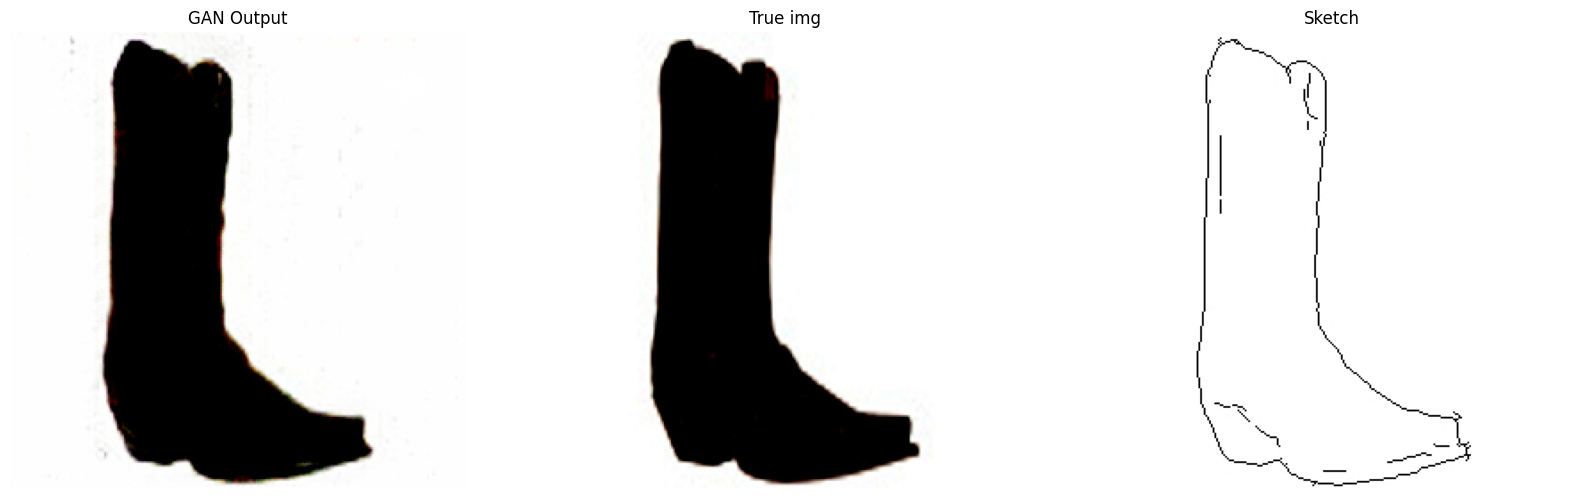

In [197]:
val_dataset = AdiGansDataset(VAL_DIR)
item = val_dataset[28]
sk = item['sketch'].unsqueeze(0).to('cuda')
ans = model(sk).cpu().detach().numpy().transpose((0, 2, 3, 1)).squeeze()
fig, ax = plt.subplots(1, 3, figsize=(20, 12))
ax[0].imshow(ans)
ax[0].set_title('GAN Output')
ax[1].imshow(item['image'].numpy().transpose(1, 2, 0))
ax[1].set_title('True img')
ax[2].imshow(item['sketch'].numpy().transpose(1, 2, 0))
ax[2].set_title('Sketch')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

In [6]:
!zip -r model.zip "checkpoints/best-checkpoint-epoch=14-d_loss=0.13.ckpt"

  adding: checkpoints/best-checkpoint-epoch=14-d_loss=0.13.ckpt (deflated 15%)


In [23]:
# !rm -rf /kaggle/working/checkpoints
# !rm -rf /kaggle/working/tb_logs
# !rm -rf /kaggle/working/file.zip